In [1]:
pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 36.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 40.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [finance-datareader]lotly]s]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-pyt

In [2]:
import pandas as pd
from pykrx import stock
from pykrx import bond
from time import sleep

from datetime import datetime
import os
import time

In [3]:
import FinanceDataReader as fdr
from pykrx import stock
import pandas as pd

start = "20171201"
end   = "20251230"

# FinanceDataReader로 코스피 종목 목록
kospi_list = fdr.StockListing("KRX")
kospi_tickers = kospi_list[kospi_list["Market"] == "KOSPI"]["Code"].tolist()

dfs = []
for t in kospi_tickers:
    df = stock.get_market_ohlcv_by_date(start, end, t)
    if df.empty:
        continue
    df.insert(0, "ticker", t)
    dfs.append(df)

kospi_ohlcv = pd.concat(dfs).reset_index().rename(columns={"index": "date"})
kospi_ohlcv.to_csv("kospi_2018_2025_ohlcv.csv", encoding="utf-8-sig")
print("완료:", kospi_ohlcv.shape)

KeyboardInterrupt: 

In [ ]:
len(kospi_ohlcv['ticker'].unique())

951

In [ ]:
import pandas as pd

# 2) 컬럼 정리
df = kospi_ohlcv.rename(columns={"날짜": "date"})

need_cols = {"date", "ticker", "종가", "거래량"}
missing = need_cols - set(df.columns)
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing} / 현재 컬럼: {list(df.columns)}")

df["date"] = pd.to_datetime(df["date"])
df["ticker"] = df["ticker"].astype(str).str.zfill(6)

# 3) 정렬 + 전일종가 계산
df = df.sort_values(["ticker", "date"])
df["prev_close"] = df.groupby("ticker")["종가"].shift(1)

# 4) 상승/하락 판정
# 신규상장 첫날 등 prev_close가 없는 행은 제외
valid = df["prev_close"].notna()

up = valid & (df["종가"] > df["prev_close"])
down = valid & (df["종가"] < df["prev_close"])
# 보합은 제외(원하면 down에 포함시키거나 별도 처리 가능)

df["up_vol"] = df["거래량"].where(up, 0)
df["down_vol"] = df["거래량"].where(down, 0)

# 5) 일별 AV/DV
daily = (
    df.groupby("date", as_index=False)[["up_vol", "down_vol"]]
      .sum()
      .rename(columns={"up_vol": "AV", "down_vol": "DV"})
)

daily["net_vol"] = daily["AV"] - daily["DV"]

# 6) McClellan Volume Oscillator (네 식의 10%, 5% EMA)
# EMA: trend(t) = (1-alpha)*trend(t-1) + alpha*net_vol(t)
alpha_fast = 0.10
alpha_slow = 0.05

daily["trend_fast"] = daily["net_vol"].ewm(alpha=alpha_fast, adjust=False).mean()
daily["trend_slow"] = daily["net_vol"].ewm(alpha=alpha_slow, adjust=False).mean()
daily["oscillator"] = daily["trend_fast"] - daily["trend_slow"]

# (선택) 누적형 Summation Index가 필요하면:
daily["summation"] = daily["oscillator"].cumsum()

# (선택) 한화처럼 20일 이동평균으로 스무딩
daily["osc_ma20"] = daily["oscillator"].rolling(20).mean()

#daily.to_csv("breadth_daily3.csv", index=False, encoding="utf-8-sig")
print("완료:", daily.shape)
print(daily.head())


In [ ]:
daily = pd.read_csv('breadth_daily3.csv')

In [ ]:
# date 타입 보장
daily["date"] = pd.to_datetime(daily["date"])

# 2023-01-01 ~ 2025-12-30 필터링
mask = (daily["date"] >= "2018-12-21") & (daily["date"] <= "2025-12-30")

out = daily.loc[mask, ["date", "oscillator"]].copy()

# CSV 저장
#out.to_csv("oscillator_2019_2025.csv", index=False, encoding="utf-8-sig")

print("저장 완료:", out.shape)
print(out.head())


저장 완료: (1724, 2)
          date    oscillator
239 2018-12-21  7.405965e+06
240 2018-12-24 -7.885108e+05
241 2018-12-26 -1.448363e+07
242 2018-12-27 -6.244125e+06
243 2018-12-28 -4.348899e+06


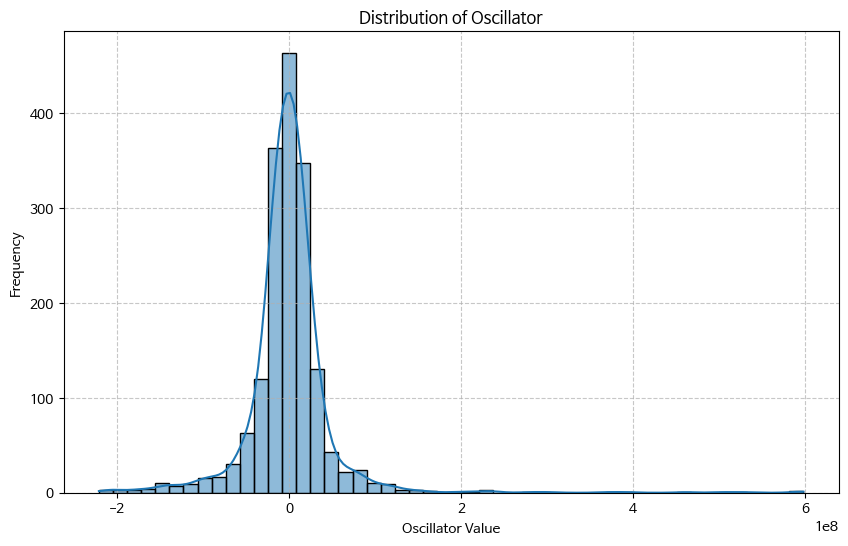

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(out['oscillator'], kde=True, bins=50)
plt.title('Distribution of Oscillator')
plt.xlabel('Oscillator Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

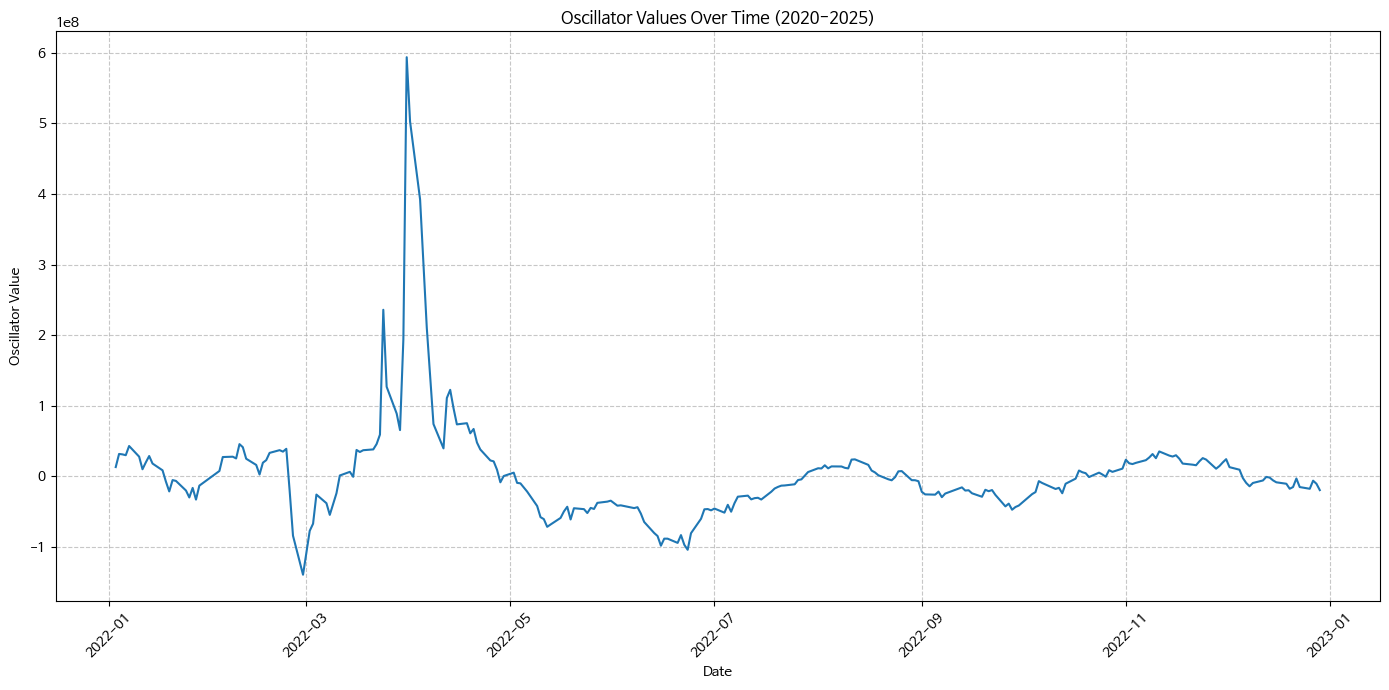

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

osc2 = out.loc[(out['date']>'2022-01-01') & (out['date']<'2023-01-01')]

plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='oscillator', data=osc2)
plt.title('Oscillator Values Over Time (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Oscillator Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
out = pd.read_csv('oscillator_2019_2025.csv')


In [ ]:
s = out["oscillator"].dropna()
q1, q3 = s.quantile([0.25, 0.75])
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outlier_ratio_iqr = ((s < lower) | (s > upper)).mean()
print(f"IQR 기준 이상치 비율: {outlier_ratio_iqr:.4%}")

IQR 기준 이상치 비율: 9.9188%


In [ ]:
s = out["oscillator"].dropna()

q01, q99 = s.quantile([0.01, 0.99])
outlier_ratio_1_99 = ((s < q01) | (s > q99)).mean()

q005, q995 = s.quantile([0.005, 0.995])
outlier_ratio_05_995 = ((s < q005) | (s > q995)).mean()

print(f"1~99% 밖 비율: {outlier_ratio_1_99:.4%}")
print(f"0.5~99.5% 밖 비율: {outlier_ratio_05_995:.4%}")

1~99% 밖 비율: 2.0882%
0.5~99.5% 밖 비율: 1.0441%


In [ ]:
from scipy.stats import norm

out = out.copy()
out["date"] = pd.to_datetime(out["date"])
out = out.sort_values("date")

window = 252          # 최근 1년
clip_c = 5            # 점수용 클립(원하면 None으로 끄기)

# rolling mean/std
roll = out["oscillator"].rolling(window, min_periods=window)
mu = roll.mean()
sd = roll.std(ddof=1)

# rolling z-score
out["osc_z_1y"] = (out["oscillator"] - mu) / sd

# 점수용 z
z_for_score = out["osc_z_1y"]
if clip_c is not None:
    z_for_score = z_for_score.clip(-clip_c, clip_c)

# 0~100 점수 (표준정규 CDF * 100)
out["osc_score_0_100"] = norm.cdf(z_for_score) * 100

# 저장 (NaN 제거: 처음 252일은 rolling 때문에 NaN)
score_df = out.loc[out["osc_score_0_100"].notna(), ["date", "osc_score_0_100"]].copy()
score_df.to_csv("osc_score_2020_2025.csv", index=False, encoding="utf-8-sig")

print("저장 완료:", score_df.shape)
print("점수 범위:", score_df["osc_score_0_100"].min(), "~", score_df["osc_score_0_100"].max())

저장 완료: (1473, 2)
점수 범위: 2.8665157187919328e-05 ~ 99.99997133484281


In [ ]:
# out은 이미 date 정렬/변환되어 있다고 가정
out_sorted = out.sort_values("date").copy()

# 1) out 자체 시작/끝 날짜
print("out 날짜 범위:", out_sorted["date"].min(), "~", out_sorted["date"].max())

# 2) oscillator 결측치 현황 (초반 결측이 있는지)
print("oscillator NaN 개수:", out_sorted["oscillator"].isna().sum())

# 3) score가 처음 생기는 날짜 + 그때까지 유효 oscillator 개수
first_idx = out_sorted["osc_score_0_100"].first_valid_index()
first_date = out_sorted.loc[first_idx, "date"]
valid_count_until_first = out_sorted.loc[:first_idx, "oscillator"].notna().sum()

print("score 첫 날짜:", first_date)
print("score 첫 시점까지 누적 유효 oscillator 개수:", valid_count_until_first)

# 4) score 첫 시점 전까지는 왜 NaN인지(표준편차 0, NaN 등) 확인
# rolling std가 0이었는지 체크하고 싶으면:
window = 252
sd = out_sorted["oscillator"].rolling(window, min_periods=window).std(ddof=1)
print("rolling std==0 개수:", (sd == 0).sum())
print("score 첫 시점의 rolling std:", sd.loc[first_idx])

out 날짜 범위: 2018-12-21 00:00:00 ~ 2025-12-30 00:00:00
oscillator NaN 개수: 0
score 첫 날짜: 2020-01-02 00:00:00
score 첫 시점까지 누적 유효 oscillator 개수: 252
rolling std==0 개수: 0
score 첫 시점의 rolling std: 14396182.020648869
